In [1]:
x=1

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import decoupler as dc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
sc.set_figure_params(vector_friendly=True, figsize=(4,4))

In [4]:
adata = sc.read('../../../pipeline/data/multigrate_mil/totalvi_pbmc_embed_3_cond_balanced/79bf894609_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', '_scvi_labels', '_scvi_batch', 'group', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

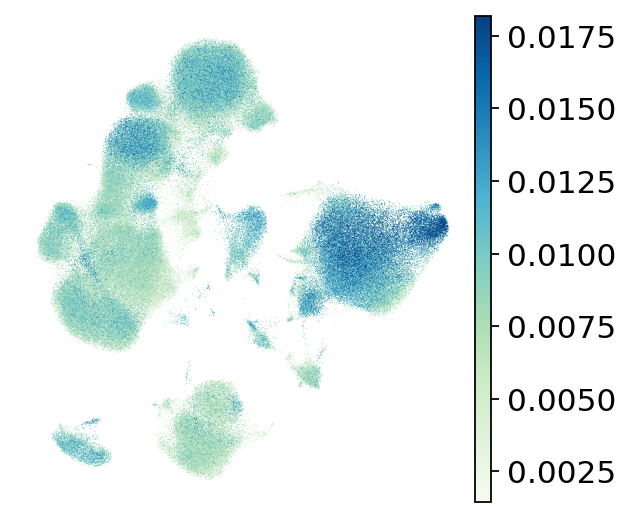

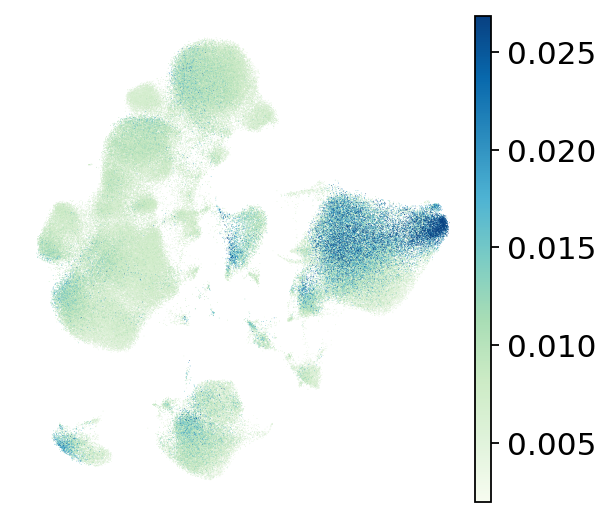

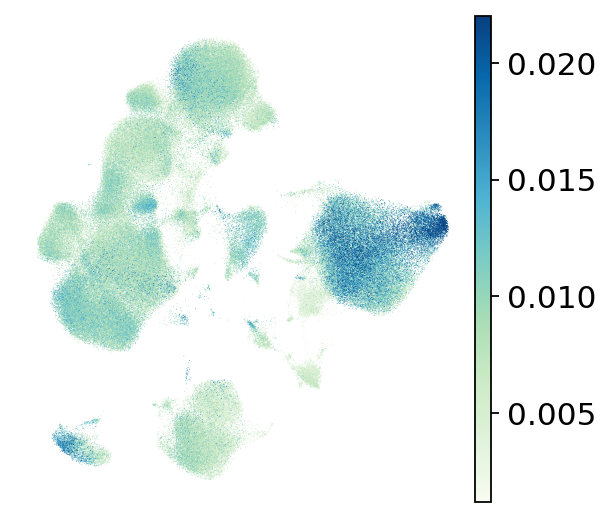

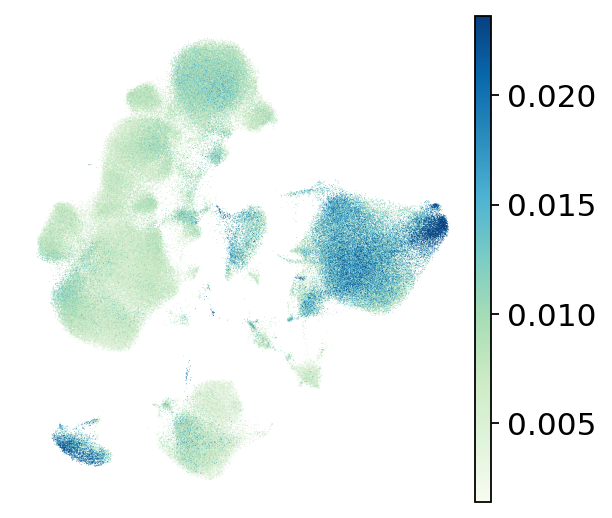

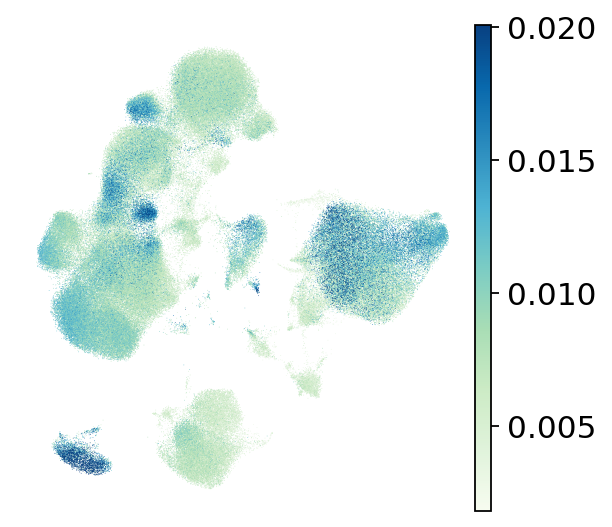

In [5]:
for i in range(5):
    sc.pl.umap(
        adata,
        color=[f'cell_attn_{i}'],
        frameon=False,
        ncols=1,
        #palette=colors,
        color_map="GnBu",
        title='',
        legend_loc=None,
        vmax='p99',
        save=f'_pbmc_cell_attn_{i}_totalvi.svg'
)

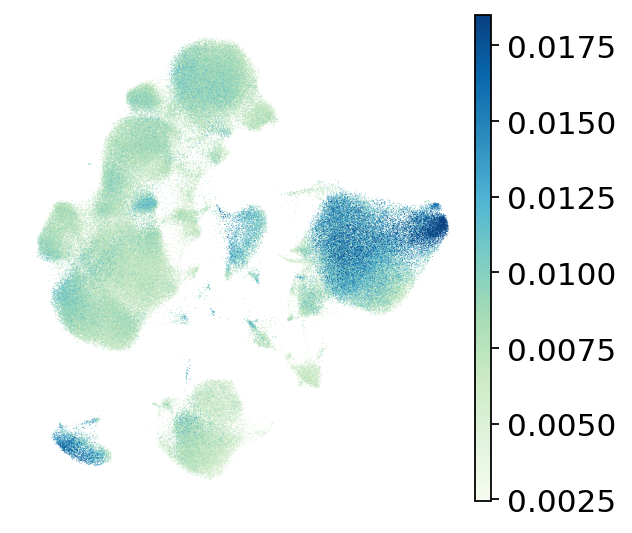

In [6]:
sc.pl.umap(
    adata,
    color=['cell_attn'],
    frameon=False,
    ncols=1,
    #palette=colors,
    color_map="GnBu",
    title='',
    legend_loc=None,
    vmax='p99',
    save='_pbmc_cell_attn_totalvi.svg'
)

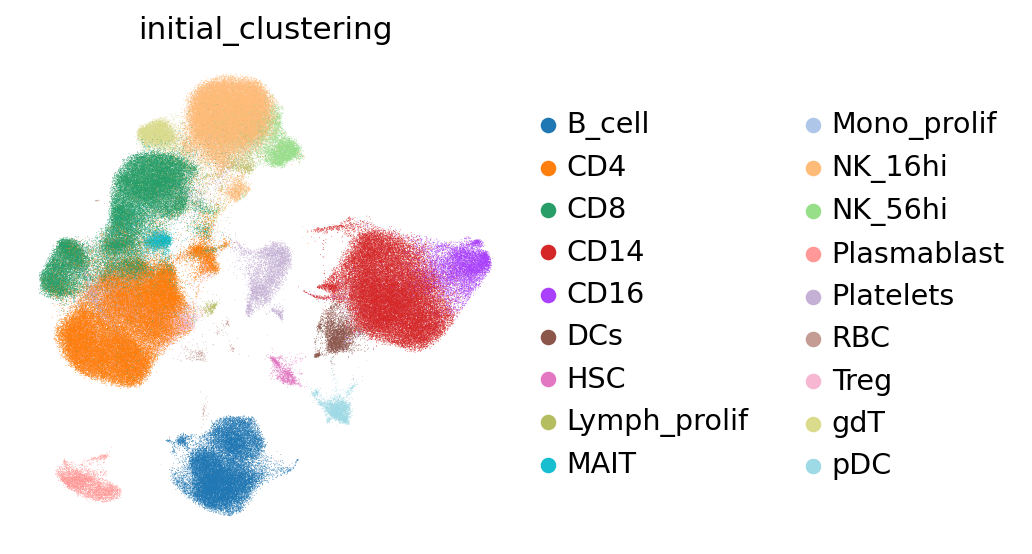

In [7]:
sc.pl.umap(
    adata,
    color=['initial_clustering'],
    ncols=1,
    frameon=False, 
    save='_pbmc_celltypes_totalvi.svg'
)

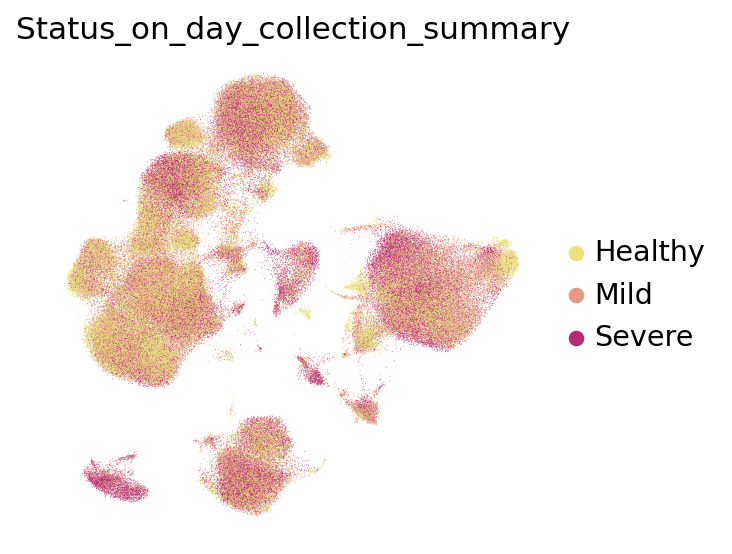

In [8]:
sc.pl.umap(
    adata,
    color=['Status_on_day_collection_summary'],
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    ncols=1,
    frameon=False,
    save='_pbmc_cond_totalvi.svg'
)

In [9]:
dfs = []
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    adata_tmp = adata[adata.obs['Status_on_day_collection_summary'] == cond].copy()
    threshold_idx = int(len(adata_tmp) * 0.9)
    threshold_value = sorted(adata_tmp.obs['cell_attn'])[threshold_idx]
    adata_tmp.obs['group'] = 'all cells'
    adata_tmp.obs.loc[adata_tmp.obs['cell_attn'] >= threshold_value, 'group'] = 'top 10% cells'
    adata.obs[f'top_cells_{cond}'] = False
    adata.obs.loc[adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs_names, f'top_cells_{cond}'] = True
    adata.obs[f'top_cells_{cond}'] = adata.obs[f'top_cells_{cond}'].astype('category')
    dfs.append(adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs[['initial_clustering', 'Status_on_day_collection_summary']])

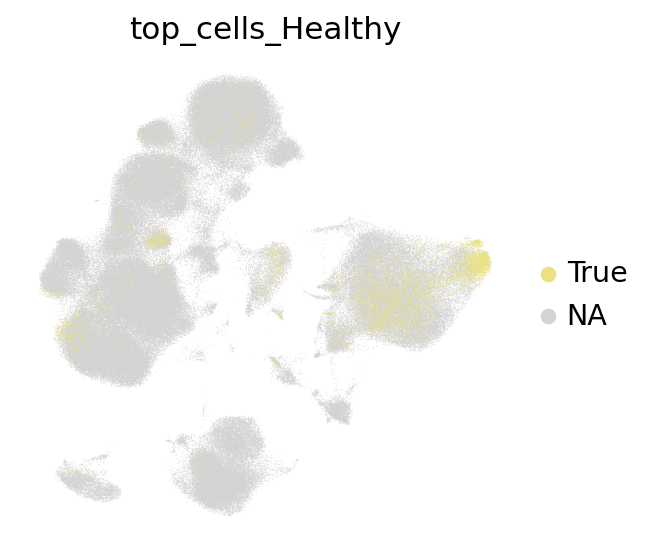

In [10]:
sc.pl.umap(
    adata,
    color=[f'top_cells_Healthy'],
    groups=[True],
    palette=['#EAE280'],
    frameon=False,
    save='_pbmc_top_healthy_totalvi.svg'
)

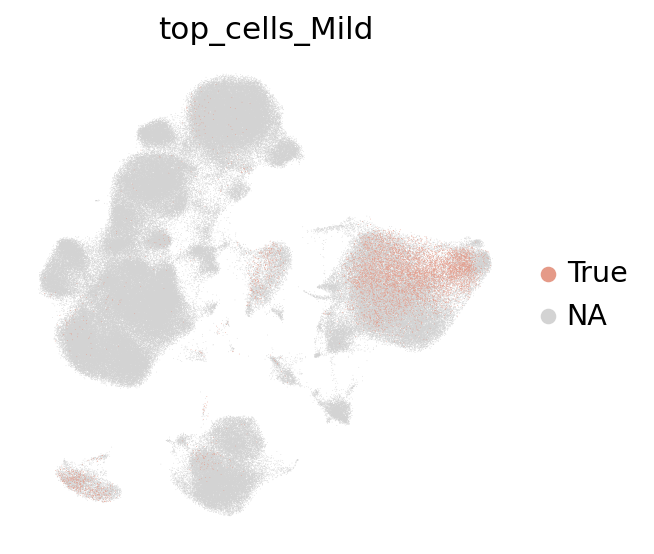

In [11]:
sc.pl.umap(adata, color=[f'top_cells_Mild'], groups=[True], palette=['#E59A88'], frameon=False, 
           save='_pbmc_top_mild_totalvi.svg'
          )

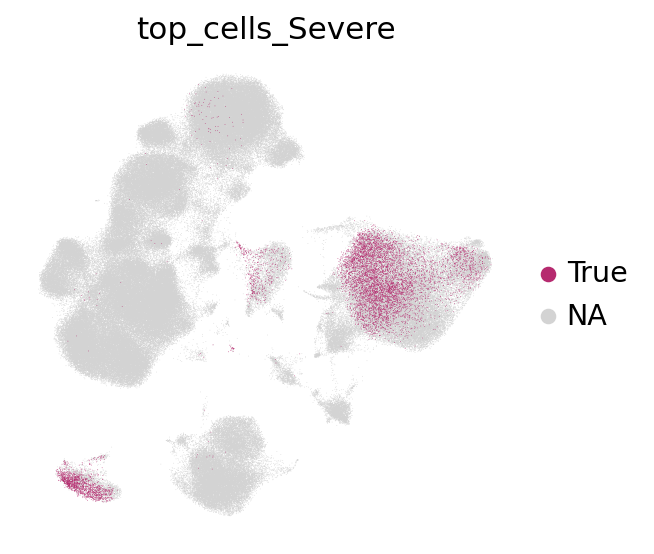

In [12]:
sc.pl.umap(adata, color=[f'top_cells_Severe'], groups=[True], palette=['#B62A6F'], frameon=False, 
           save='_pbmc_top_severe_totalvi.svg'
          )

In [13]:
df = pd.read_csv('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/reports/best.tsv', sep='\t', index_col=None)
task = 'totalvi_pbmc_embed_3_cond_balanced'

In [14]:
runs = {}
yerr = {}
df_task = df[df['task'] == task]
for method in np.unique(df_task['method']):
    runs[method] = eval(df_task.loc[df_task['method'] == method, 'accuracies'].values[0])
    yerr[method] = np.array(runs[method]).std()

df_tmp = df_task[['method', 'accuracy']]
df_tmp.index = df_tmp['method']
df_tmp = df_tmp[['accuracy']].sort_values('accuracy', ascending=False)
df_tmp = df_tmp.T

yerr_sorted = [yerr[method] for method in df_tmp.columns]

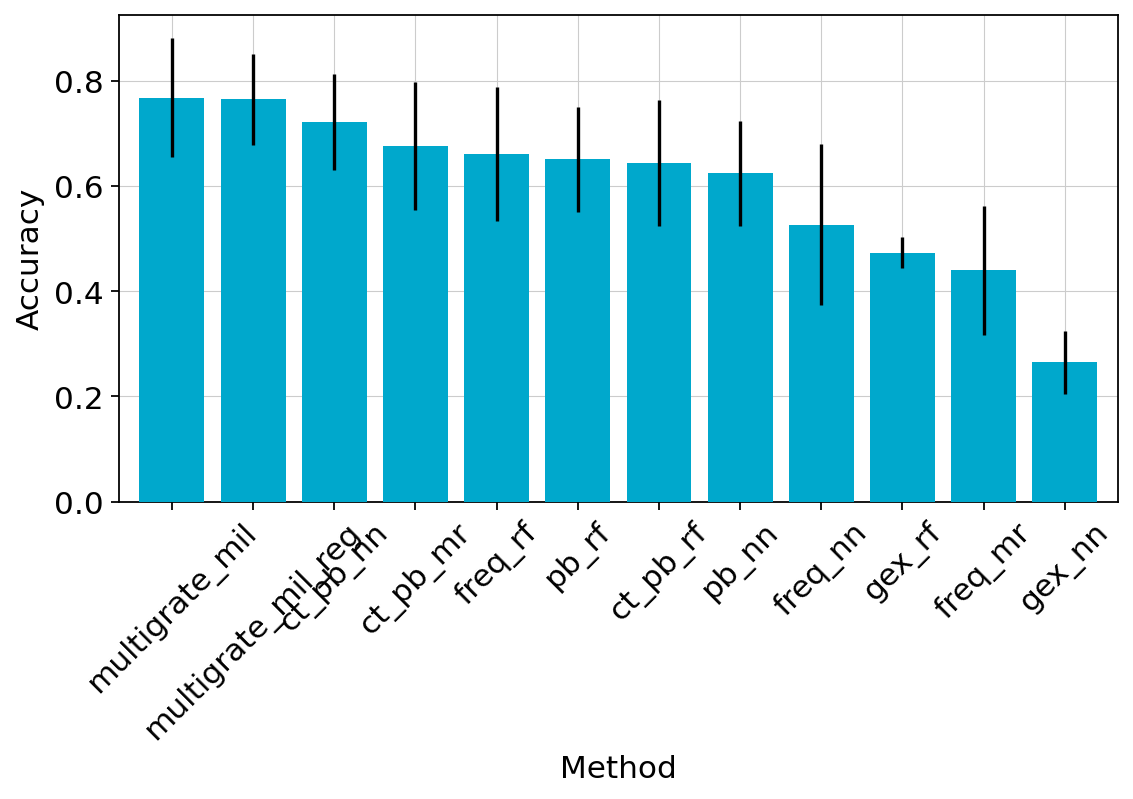

In [15]:
ax = df_tmp.T.plot(kind='bar', zorder=3, figsize=(8, 4), color=["#00a8cc"], rot=45, yerr=yerr_sorted, width=0.8)
ax.get_legend().remove()
ax.grid(zorder=0, linewidth=0.5)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('')
plt.savefig('figures/pbmc_accuracy_totalvi.svg', bbox_inches='tight')

### patient repr

In [16]:
adata.obs

,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,full_clustering,initial_clustering,Resample,Collection_Day,...,group,cell_attn_0,cell_attn_1,cell_attn_2,cell_attn_3,cell_attn_4,cell_attn,top_cells_Healthy,top_cells_Mild,top_cells_Severe
covid_index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACCACGA-newcastle65,newcastle65,1351,1351,4278.0,178.0,4.160823,CD4.Naive,CD4,Initial,D0,...,0,0.003498,0.006332,0.004972,0.008228,0.013029,0.007212,False,False,False
AAACCTGAGATGTCGG-newcastle65,newcastle65,1921,1921,4740.0,127.0,2.679325,NK_16hi,NK_16hi,Initial,D0,...,0,0.007218,0.008724,0.006771,0.010106,0.007323,0.008029,False,False,False
AAACCTGAGGCGATAC-newcastle65,newcastle65,1056,1056,2875.0,198.0,6.886957,CD4.Naive,Treg,Initial,D0,...,0,0.003482,0.006817,0.008673,0.004872,0.007112,0.006191,False,False,False
AAACCTGAGTACACCT-newcastle65,newcastle65,2140,2140,5260.0,316.0,6.007605,NK_16hi,NK_16hi,Initial,D0,...,0,0.009345,0.006740,0.006016,0.008051,0.006441,0.007319,False,False,False
AAACCTGAGTGAATTG-newcastle65,newcastle65,1620,1620,4043.0,232.0,5.738313,CD8.EM,CD4,Initial,D0,...,0,0.003126,0.006954,0.004168,0.007448,0.006802,0.005699,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,BGCV15_CV0176,1631,1631,5325.0,184.0,3.455399,CD4.CM,CD4,Resample,D28,...,0,0.003125,0.009566,0.008444,0.005040,0.008991,0.007033,False,False,False
BGCV15_TTTGGTTTCAAGATCC-1,BGCV15_CV0944,2503,2503,6681.0,264.0,3.951504,NK_16hi,NK_16hi,Initial,D0,...,0,0.005152,0.006392,0.013442,0.009796,0.007581,0.008473,False,False,False
BGCV15_TTTGTCAAGGCGATAC-1,BGCV15_CV0176,2401,2401,8633.0,490.0,5.675895,CD4.CM,CD4,Resample,D28,...,0,0.004368,0.006332,0.006824,0.005799,0.004930,0.005651,False,False,False


In [17]:
tmp = adata

In [18]:
for i in range(tmp.X.shape[1]):
    tmp.obs[f'latent{i}'] = tmp.X[:, i].copy()
    tmp.obs[f'latent{i}_weighted'] = tmp.obs[f'latent{i}'] * tmp.obs['cell_attn']
tmp.obs[['latent0', 'latent0_weighted', 'cell_attn']]

,latent0,latent0_weighted,cell_attn
covid_index,,,
AAACCTGAGACCACGA-newcastle65,0.436706,0.003149,0.007212
AAACCTGAGATGTCGG-newcastle65,0.486123,0.003903,0.008029
AAACCTGAGGCGATAC-newcastle65,0.713838,0.004419,0.006191
AAACCTGAGTACACCT-newcastle65,-0.239196,-0.001751,0.007319
AAACCTGAGTGAATTG-newcastle65,0.180086,0.001026,0.005699
...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,-0.074418,-0.000523,0.007033
BGCV15_TTTGGTTTCAAGATCC-1,-0.308759,-0.002616,0.008473
BGCV15_TTTGTCAAGGCGATAC-1,-0.407283,-0.002301,0.005651


In [19]:
df = tmp.obs[[f'latent{i}' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,0.143070,-0.093714,-0.066191,-0.078882,-0.143489,0.443984,0.105943,0.112322,-0.011753,-0.017626,...,-0.170066,-0.160538,-0.286843,0.200944,0.824169,0.083622,0.069089,0.003678,Severe,Sanger
AP4,0.157995,-0.286253,-0.087096,-0.071772,-0.155348,0.265895,0.081076,0.064086,-0.000333,0.096973,...,-0.024883,-0.069524,-0.152453,0.084929,1.122453,0.037243,-0.027911,0.070297,Mild,Sanger
AP5,0.135439,0.244856,-0.290716,-0.124805,-0.146129,0.513715,0.191003,-0.120545,0.079034,-0.096344,...,-0.028254,0.011604,0.063725,0.050112,0.870086,-0.270901,0.086383,0.073393,Severe,Sanger


In [20]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [21]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [22]:
loo = LeaveOneOut()

In [23]:
mean_train_accuracies = {}
mean_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    mean_train_accuracies[k] = train_accuracies
    mean_test_accuracies[k] = test_accuracies

In [24]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(mean_train_accuracies[k])))
    print(np.mean(np.array(mean_test_accuracies[k])))

k = 3:
0.7300170068027212
0.5918367346938775
k = 5:
0.6513605442176871
0.5306122448979592
k = 7:
0.6424319727891158
0.6122448979591837
k = 9:
0.7172619047619048
0.6122448979591837


In [25]:
sc.pp.neighbors(pb)

In [26]:
sc.tl.umap(pb)

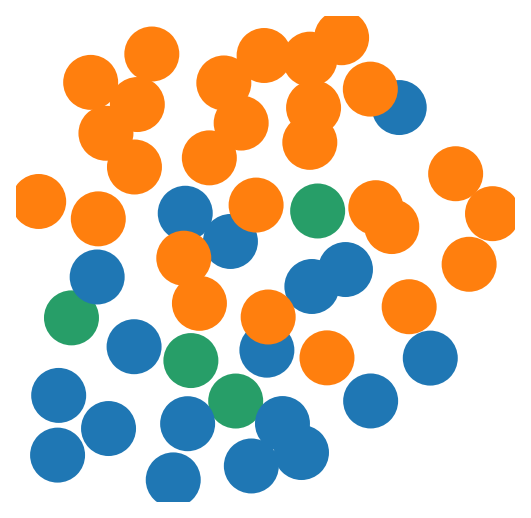

In [27]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_site.svg'
)

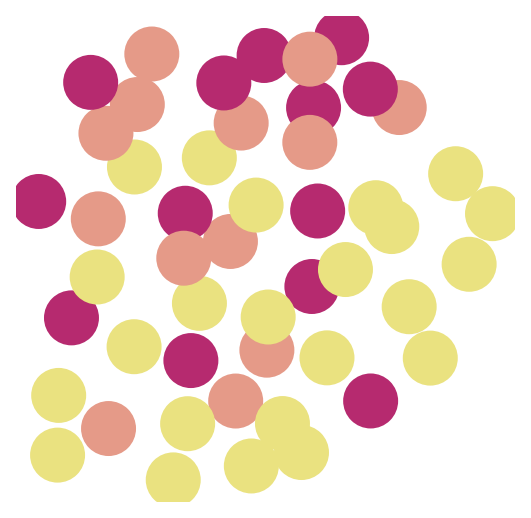

In [28]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_mean_totalvi.svg'
)

In [29]:
df = tmp.obs[[f'latent{i}_weighted' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('sum')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0_weighted,latent1_weighted,latent2_weighted,latent3_weighted,latent4_weighted,latent5_weighted,latent6_weighted,latent7_weighted,latent8_weighted,latent9_weighted,...,latent12_weighted,latent13_weighted,latent14_weighted,latent15_weighted,latent16_weighted,latent17_weighted,latent18_weighted,latent19_weighted,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,4.051764,-2.792733,-5.079264,-4.502957,-4.269825,19.448002,3.792478,5.886301,-2.557374,-2.897978,...,-4.731063,-4.067702,-8.300514,6.401134,24.291693,2.273953,0.580876,-1.494237,Severe,Sanger
AP4,6.876795,-13.313416,-8.765698,-8.233267,-7.474565,19.433498,4.426328,6.735036,-0.612986,6.112316,...,-1.697978,-4.132929,-8.119596,5.200953,60.445366,2.634439,-3.471481,2.866159,Mild,Sanger
AP5,0.040117,18.144413,-21.212790,-13.385013,-6.938540,47.242805,16.328091,-5.238396,7.133909,-8.896918,...,-4.454415,-1.918400,9.879083,5.201791,47.173935,-12.692877,1.784581,6.320951,Severe,Sanger


In [30]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [31]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [32]:
loo = LeaveOneOut()

In [33]:
attn_train_accuracies = {}
attn_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    attn_train_accuracies[k] = train_accuracies
    attn_test_accuracies[k] = test_accuracies

In [34]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(attn_train_accuracies[k])))
    print(np.mean(np.array(attn_test_accuracies[k])))

k = 3:
0.7750850340136055
0.6938775510204082
k = 5:
0.7151360544217688
0.673469387755102
k = 7:
0.6913265306122449
0.5918367346938775
k = 9:
0.6717687074829931
0.6326530612244898


In [35]:
sc.pp.neighbors(pb)

In [36]:
sc.tl.umap(pb)

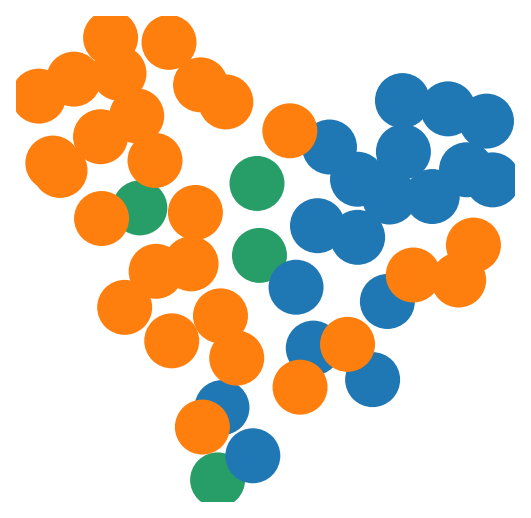

In [37]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_weighted_site.svg'
)

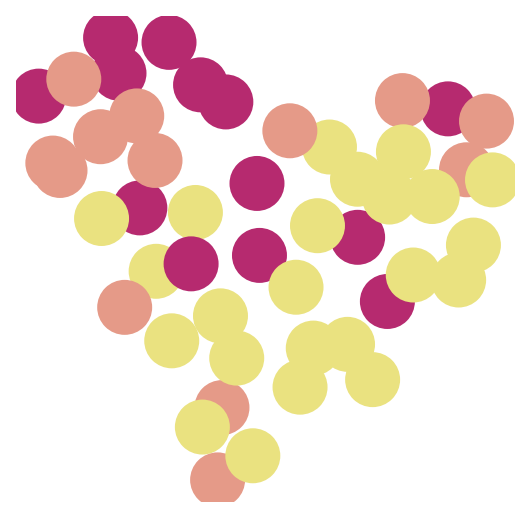

In [38]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_attn_weighted_totalvi.svg'
)

In [39]:
df1 = pd.DataFrame(attn_test_accuracies)
df2 = pd.DataFrame(mean_test_accuracies)

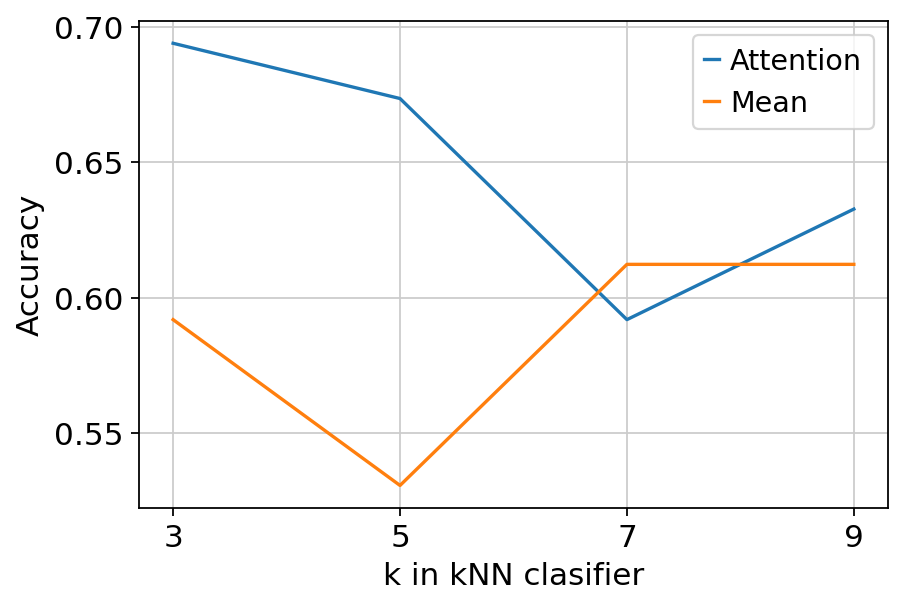

In [40]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('figures/mil_knn_classifier.svg', bbox_inches='tight')

In [41]:
adata_top = adata[(adata.obs['top_cells_Healthy'] == True) | (adata.obs['top_cells_Mild'] == True) | (adata.obs['top_cells_Severe'] == True)].copy()
adata_top

AnnData object with n_obs × n_vars = 25606 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', '_scvi_labels', '_scvi_batch', 'group', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_Healthy', 'top_cells_Mild', 'top_cells_Severe', 'latent0', 'latent0_weighted', 'latent1', 'latent1_weighted', 'latent2', 'latent2_weighted', 'latent3', 'latent3_weighted', 'latent4', 'latent4_weighted', 'latent5', 'latent5_weighted', 'latent6', 'latent6_weighted', 'latent7', 'latent7_weighted', 'latent8', 'latent8_weighted', 'latent9', 'latent9_weighted', 'latent10',

In [42]:
tmp_top = adata_top

In [43]:
for i in range(adata_top.X.shape[1]):
    tmp_top.obs[f'latent{i}'] = tmp_top.X[:, i].copy()

In [44]:
df = tmp_top.obs[[f'latent{i}' for i in range(tmp_top.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp_top.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,-0.119139,-0.144893,-0.381257,-0.403623,-0.216264,1.515404,0.187553,0.152041,-0.390190,-0.550130,...,0.114165,0.082396,0.098843,0.134786,-0.210067,-0.212251,-0.375794,-0.435387,Severe,Sanger
AP4,-0.428368,-0.153222,-0.580925,-0.657277,0.153720,1.397363,0.214455,0.078666,0.341537,-0.069608,...,-0.292236,-0.182521,-0.194899,0.362094,-0.030176,0.185907,-0.207711,0.041397,Mild,Sanger
AP5,-0.887666,0.161563,-0.275147,-0.463916,0.003290,2.068494,0.709189,-0.074823,0.424499,-0.360888,...,-0.370942,-0.225518,0.575981,0.333541,-0.152644,0.388907,-0.262822,0.174666,Severe,Sanger


In [45]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [46]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [47]:
loo = LeaveOneOut()

In [48]:
top_train_accuracies = {}
top_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    top_train_accuracies[k] = train_accuracies
    top_test_accuracies[k] = test_accuracies

In [49]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(top_train_accuracies[k])))
    print(np.mean(np.array(top_test_accuracies[k])))

k = 3:
0.913690476190476
0.673469387755102
k = 5:
0.7929421768707483
0.7346938775510204
k = 7:
0.8469387755102042
0.7959183673469388
k = 9:
0.836309523809524
0.7346938775510204


In [50]:
sc.pp.neighbors(pb)

In [51]:
sc.tl.umap(pb)

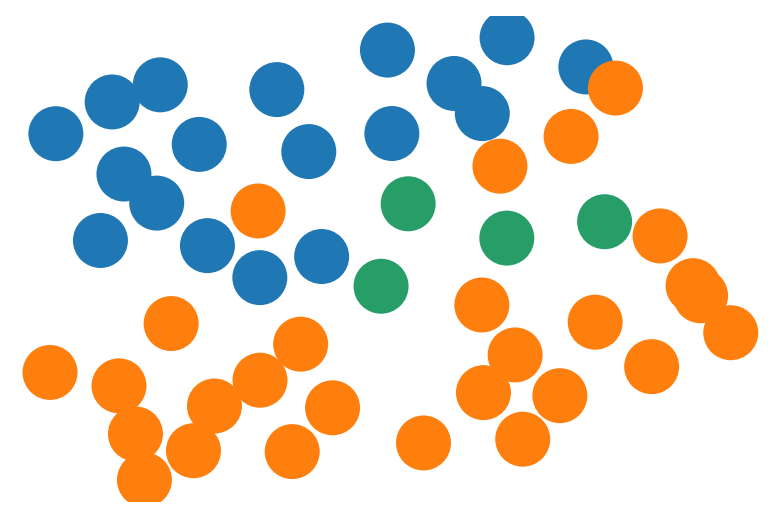

In [52]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_site.svg'
)

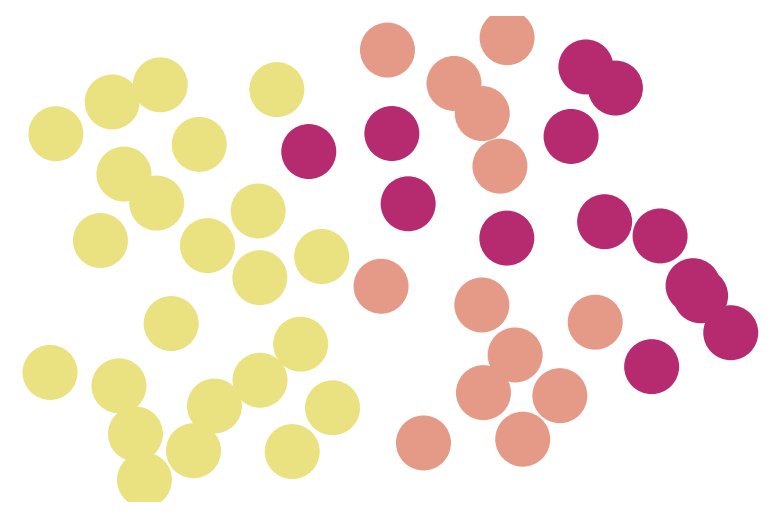

In [53]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_top10perc_totalvi.svg'
)

In [54]:
df3 = pd.DataFrame(top_test_accuracies)

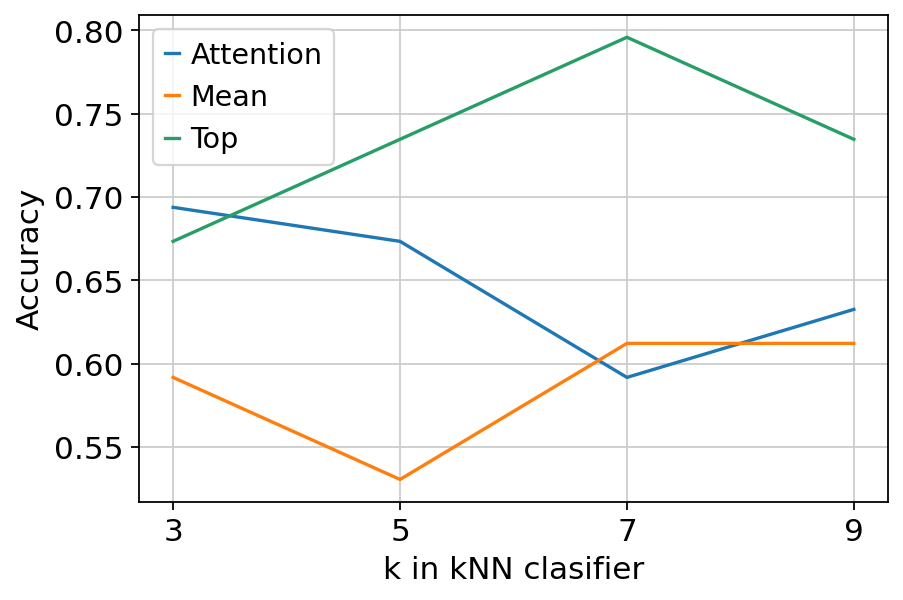

In [55]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.plot(df3.mean().index.astype(str).values, df3.mean().values, label='Top')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_knn_classifier_totalvi.svg', bbox_inches='tight')

In [56]:
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', '_scvi_labels', '_scvi_batch', 'group', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_Healthy', 'top_cells_Mild', 'top_cells_Severe', 'latent0', 'latent0_weighted', 'latent1', 'latent1_weighted', 'latent2', 'latent2_weighted', 'latent3', 'latent3_weighted', 'latent4', 'latent4_weighted', 'latent5', 'latent5_weighted', 'latent6', 'latent6_weighted', 'latent7', 'latent7_weighted', 'latent8', 'latent8_weighted', 'latent9', 'latent9_weighted', 'latent10'

In [57]:
dfs = {}
for top_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    threshold_idx = int(len(adata) * top_percentage)
    threshold_value = sorted(adata.obs['cell_attn'])[threshold_idx]
    adata_top = adata[adata.obs['cell_attn'] >= threshold_value].copy()
    for i in range(adata_top.X.shape[1]):
        adata_top.obs[f'latent{i}'] = adata_top.X[:, i].copy()
    df = adata_top.obs[[f'latent{i}' for i in range(adata_top.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
    df = df.join(adata_top.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
    pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
    pb.obs = df[['Status_on_day_collection_summary', 'Site']]
    X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
    y = df[['Status_on_day_collection_summary']].values.ravel()
    loo = LeaveOneOut()
    top_train_accuracies = {}
    top_test_accuracies = {}
    for k in [3, 5, 7, 9]:
        train_accuracies = []
        test_accuracies = []
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            knn = KNeighborsClassifier(n_neighbors = k)
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            knn.fit(X_train, y_train)
            y_train_predict = knn.predict(X_train)
            y_test_predict = knn.predict(X_test)
            train_accuracies.append(np.mean(y_train_predict == y_train))
            test_accuracies.append(np.mean(y_test_predict == y_test))
        # top_train_accuracies[k] = train_accuracies
        top_test_accuracies[k] = test_accuracies
    dfs[top_percentage] = pd.DataFrame(top_test_accuracies)

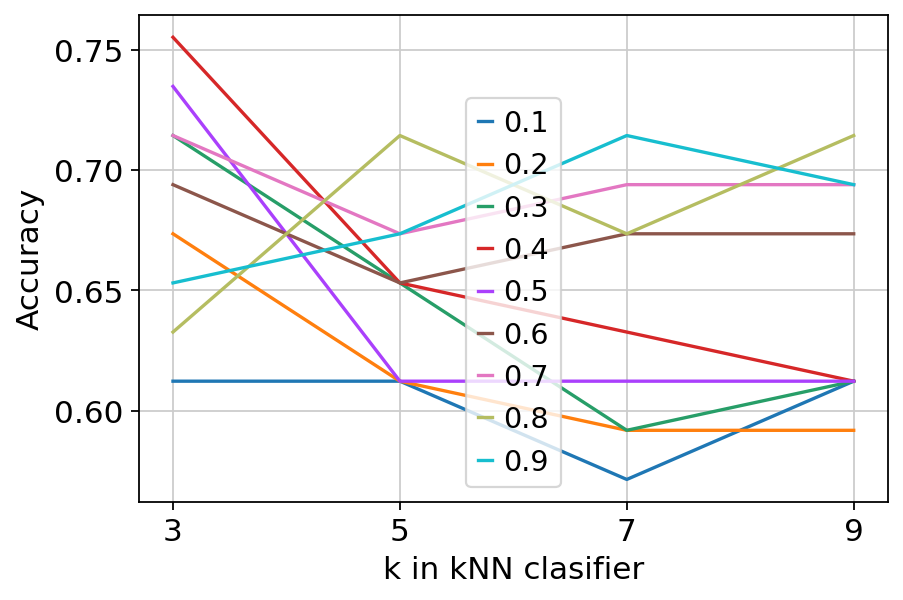

In [58]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
for top_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(dfs[top_percentage].mean().index.astype(str).values, dfs[top_percentage].mean().values, label=top_percentage)
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_knn_classifier_top_totalvi.svg', bbox_inches='tight')